# Week 2: Predicting time series

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

Let's get started!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data


The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating time series data that greatly resembles the one from last week but with some differences.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the previous week.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html). 

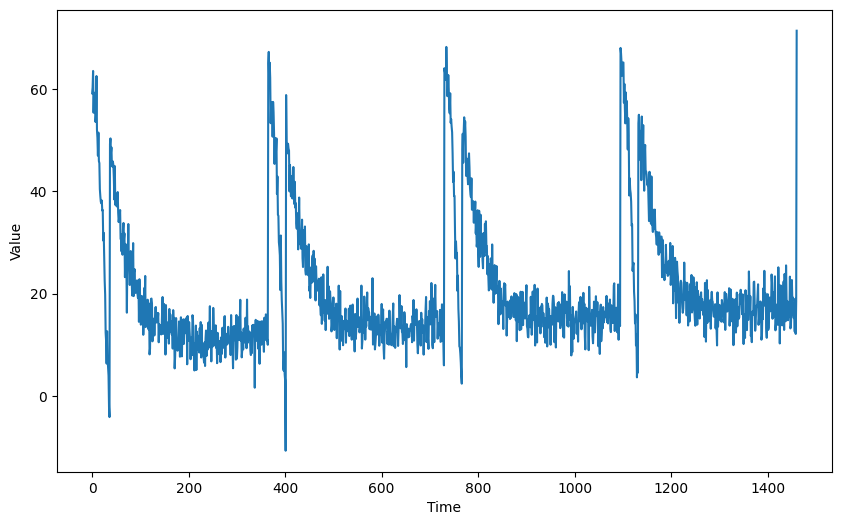

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Splitting the data

Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Processing the data

As you saw on the lectures you can feed the data for training by creating a dataset with the appropiate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. To do so complete the `windowed_dataset` function below.

Notice that this function receives a `series`, `window_size`, `batch_size` and `shuffle_buffer` and the last three of these default to the "global" values defined earlier.

Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) about `TF Datasets` if you need any help.

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    
    ### START CODE HERE
    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffle it
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Split it into the features and labels
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    
    ### END CODE HERE
    
    return dataset

To test your function you will be using a `window_size` of 1 which means that you will use each value to predict the next one. This for 5 elements since a `batch_size` of 5 is used and no shuffle since `shuffle_buffer` is set to 1.

Given this, the batch of features should be identical to the first 5 elements of the `series_train` and the batch of labels should be equal to elements 2 through 6 of the `series_train`.

In [6]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


**Expected Output:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True
```

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Hint:
- You will only need `Dense` layers.
- Do not include `Lambda` layers. These are not required and are incompatible with the `HDF5` format which will be used to save your model for grading.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.

In [7]:
def create_model(window_size=G.WINDOW_SIZE):

    ### START CODE HERE

    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(1)    
    ]) 

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9))
    
    ### END CODE HERE

    return model

In [8]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train it
model.fit(dataset, epochs=100)

Epoch 1/100


/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 135.6096
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - loss: 45.0024
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - loss: 48.2449
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss: 42.2588
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 37.3464
Epoch 6/100


2024-07-07 18:22:53.949110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-07 18:22:54.011383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.053130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.096644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.3154 
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 29.5921
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - loss: 30.5023
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - loss: 31.8760
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - loss: 23.5837
Epoch 11/100


2024-07-07 18:22:54.217392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.261642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.305674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.351011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.394416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - loss: 29.0673
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 33.3978
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 24.4577
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 25.0645
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 24.0033
Epoch 16/100


2024-07-07 18:22:54.438619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.483125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.526478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.568844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.610707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 38.6030
Epoch 17/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 34.5244
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 20.7486
Epoch 19/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 25.6184
Epoch 20/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 27.3892
Epoch 21/100


2024-07-07 18:22:54.654070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.697656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.739769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.782682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.824168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 22.4467
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss: 19.7527
Epoch 23/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 31.0308
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 26.2950
Epoch 25/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 26.0375
Epoch 26/100


2024-07-07 18:22:54.869511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.912410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.953429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:54.995396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.037592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 37.7658
Epoch 27/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 27.7663
Epoch 28/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 22.8174
Epoch 29/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 29.4484
Epoch 30/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 21.6898
Epoch 31/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 13.6225

2024-07-07 18:22:55.079426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.121093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.161854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.203847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.244881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss: 22.7291
Epoch 32/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 32.2799
Epoch 33/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 35.1360
Epoch 34/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 26.5751
Epoch 35/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 30.5524
Epoch 36/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 13.8532

2024-07-07 18:22:55.285432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.327160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.367492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.409196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.450949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss: 25.8553
Epoch 37/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 20.1218
Epoch 38/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 23.9200
Epoch 39/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 22.7594
Epoch 40/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 34.1715
Epoch 41/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 39.6966

2024-07-07 18:22:55.492400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.534007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.575535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.617237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.658651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 24.4291
Epoch 42/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 26.7152
Epoch 43/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 23.1465
Epoch 44/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 26.0792
Epoch 45/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 23.1050
Epoch 46/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 104.5984

2024-07-07 18:22:55.699666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.741447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.782998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.824147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.865483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 34.1579
Epoch 47/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 21.1120
Epoch 48/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 26.0669
Epoch 49/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 19.9696
Epoch 50/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 20.3076
Epoch 51/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 12.5276

2024-07-07 18:22:55.906749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.948253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:55.989677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.031006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.072656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 21.4704
Epoch 52/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 24.0603
Epoch 53/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - loss: 19.0253
Epoch 54/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 18.4498
Epoch 55/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss: 26.1496
Epoch 56/100


2024-07-07 18:22:56.114206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.181538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.225731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.269691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.312369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss: 36.5924
Epoch 57/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 25.8581
Epoch 58/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 24.2778
Epoch 59/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 32.8306
Epoch 60/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 22.2373
Epoch 61/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 12.7417

2024-07-07 18:22:56.354120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.396019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.437214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.478174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.519690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 25.0254
Epoch 62/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 17.5595
Epoch 63/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 21.6760
Epoch 64/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 24.7668
Epoch 65/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 22.2692
Epoch 66/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.8675

2024-07-07 18:22:56.561071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.602879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.644240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.685950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.727480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 19.5656
Epoch 67/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 23.0145
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 23.2881
Epoch 69/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 21.7558
Epoch 70/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 20.1371
Epoch 71/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 104.5212

2024-07-07 18:22:56.768457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.810088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.851418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.892853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:56.934353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 27.2510
Epoch 72/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 21.5941
Epoch 73/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 30.6954
Epoch 74/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 27.4498
Epoch 75/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 18.2981
Epoch 76/100


2024-07-07 18:22:56.975604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.017836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.061305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.102758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.143966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 22.8621
Epoch 77/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 28.6172
Epoch 78/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 23.3733
Epoch 79/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 28.9740
Epoch 80/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 15.4786
Epoch 81/100


2024-07-07 18:22:57.185834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.227846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.270034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.311973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.354179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 25.5540
Epoch 82/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 21.5180
Epoch 83/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 19.8044
Epoch 84/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 20.4879
Epoch 85/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 21.8462
Epoch 86/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.1427

2024-07-07 18:22:57.396668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.436427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.477212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.518951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.560394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 23.3020
Epoch 87/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 24.0638
Epoch 88/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 15.4300
Epoch 89/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 17.7164
Epoch 90/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 22.8376
Epoch 91/100


2024-07-07 18:22:57.601877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.643604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.685701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.727153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.769512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 20.8005
Epoch 92/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 24.8669
Epoch 93/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 17.6610
Epoch 94/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 32.6308
Epoch 95/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 19.2018
Epoch 96/100


2024-07-07 18:22:57.811162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.854019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.896234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.938234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:57.980333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 20.0678
Epoch 97/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 25.3101
Epoch 98/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 18.7649
Epoch 99/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 21.5753
Epoch 100/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 25.9735


2024-07-07 18:22:58.021870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:58.064599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:58.105473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:58.146811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:22:58.188938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [9]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mse(true_series, forecast).numpy()
    mae = tf.keras.metrics.mae(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

For this, run the cell below which uses the `generate_forecast` function to compute the forecast. This function generates the next value given a set of the previous `window_size` points for every point in the validation set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


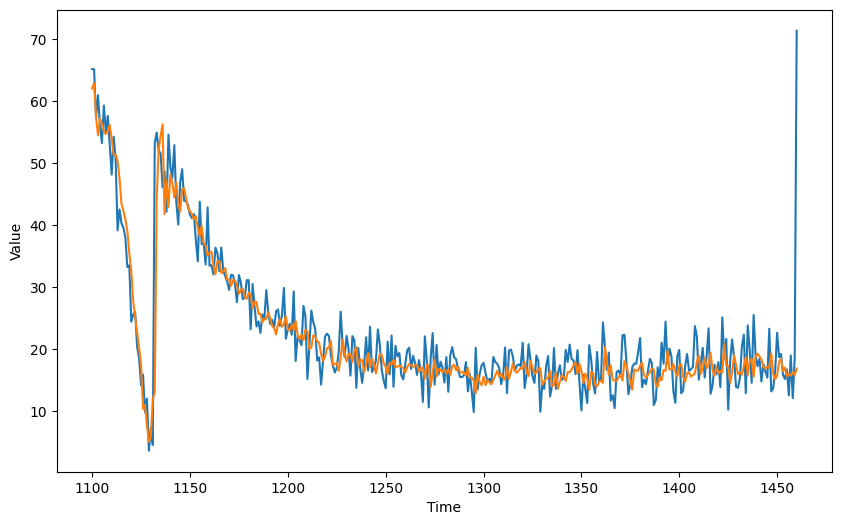

In [10]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/forecast.png" width="500"/>
</div>

In [11]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 25.84, mae: 3.10 for forecast


**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a HDF5 file file which will be used for grading and after doing so, submit your assigment for grading.


- Make sure you didn't use `Lambda` layers in your model since these are incompatible with the `HDF5` format which will be used to save your model for grading.


- This environment includes a dummy `my_model.h5` file which is just a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [12]:
# Save your model in HDF5 format
model.save('my_model.h5')

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series while also learning how to leverage Tensorflow's Dataset class to process time series data!

**Keep it up!**